## Packages to be installed

In [2]:
# !pip install crepes

## Libraries

In [2]:
import pandas as pd
import numpy as np
from crepes import ConformalClassifier, ConformalPredictiveSystem
from crepes.extras import hinge, margin, binning, DifficultyEstimator

## Data

In [3]:
df_calibration = pd.read_csv('cal.csv')
df_testing = pd.read_csv('test.csv')
df_equal = df_calibration.query('gt_obj_id == pred_obj_id').sort_values(by=['gt_obj_id', 'pred_obj_id'])
[df_calibration.shape, df_equal.shape]

# for i in range(9):
#     print(df_equal[df_equal.gt_obj_id == i].shape)

[(5000, 12), (3296, 12)]

In [16]:
df_equal[df_equal.gt_obj_id == 0]

,gt_obj_id,pred_obj_id,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
26,0,0,0.693477,0.195131,0.060799,0.007634,0.011224,0.002638,0.001738,0.000388,0.016468,0.010503
29,0,0,0.404310,0.000355,0.131839,0.067560,0.068985,0.043520,0.003398,0.219210,0.025683,0.035139
37,0,0,0.987304,0.000058,0.003143,0.000779,0.004085,0.000147,0.000023,0.003999,0.000337,0.000125
40,0,0,0.837609,0.003275,0.048865,0.004343,0.052951,0.001436,0.000132,0.043575,0.003539,0.004274
70,0,0,0.630026,0.006565,0.022347,0.017075,0.037663,0.003591,0.001659,0.115482,0.067297,0.098295
...,...,...,...,...,...,...,...,...,...,...,...,...
4937,0,0,0.994351,0.000199,0.000293,0.000137,0.001176,0.000004,0.000004,0.000232,0.001304,0.002300
4956,0,0,0.443135,0.000313,0.390563,0.040178,0.015807,0.069918,0.000528,0.028139,0.005781,0.005638
4967,0,0,0.983542,0.000599,0.001474,0.000608,0.003470,0.000054,0.000035,0.006478,0.000382,0.003357
4977,0,0,0.614465,0.108314,0.010995,0.003358,0.018963,0.000866,0.000211,0.003899,0.226622,0.012307


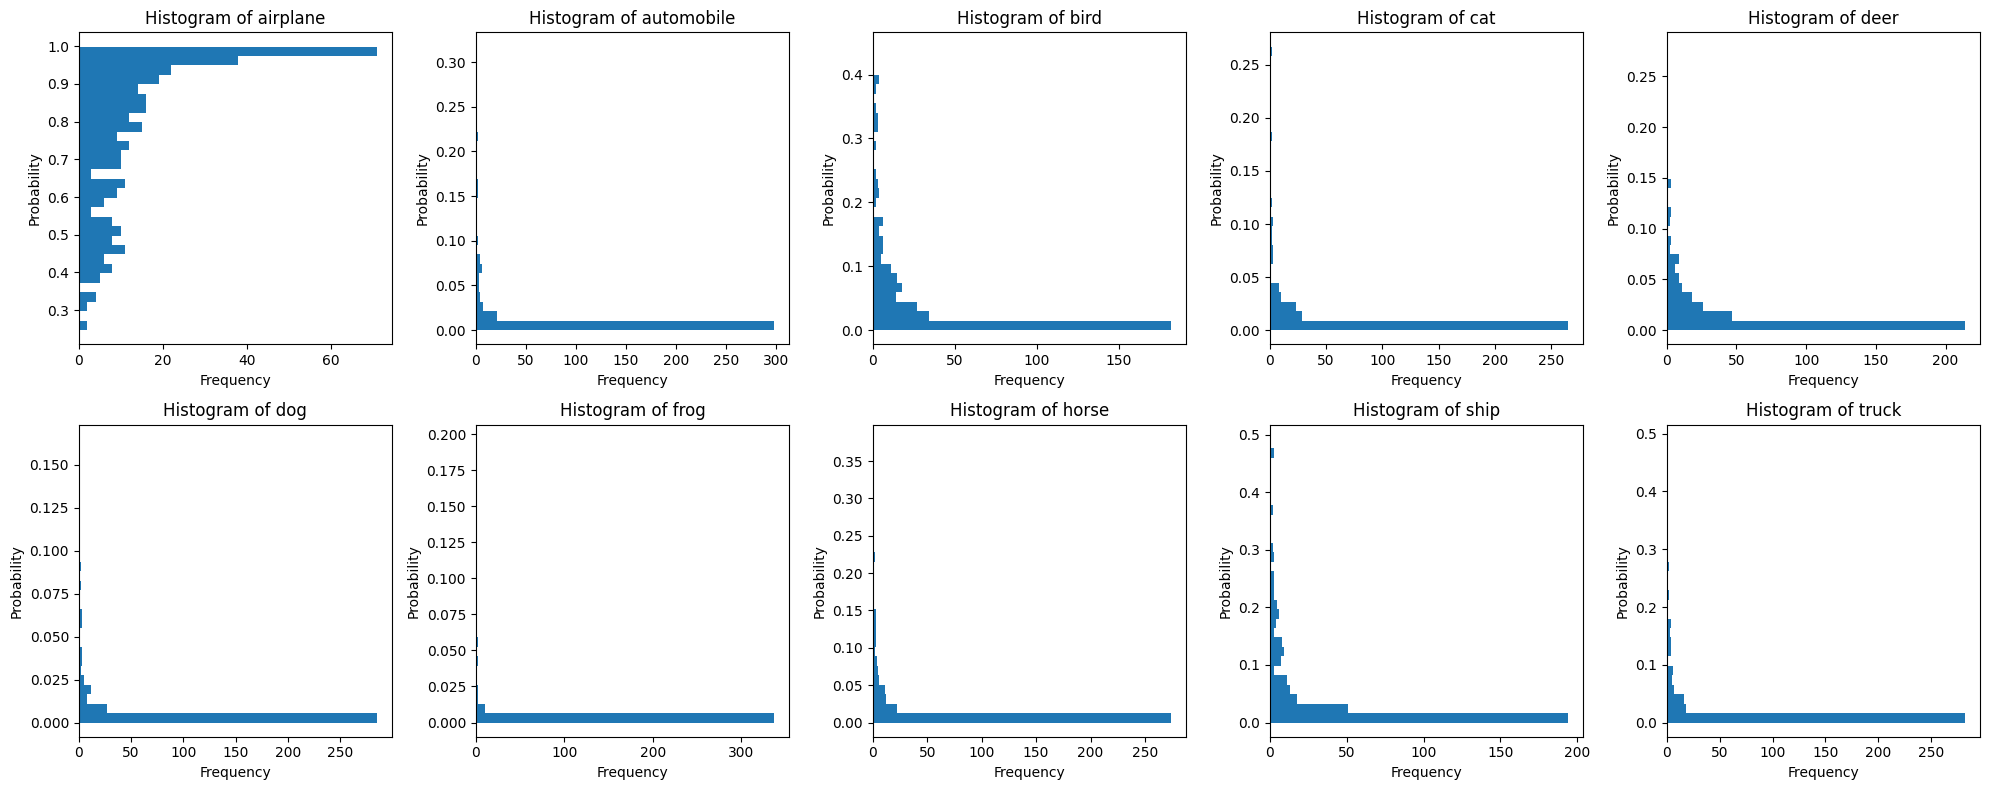

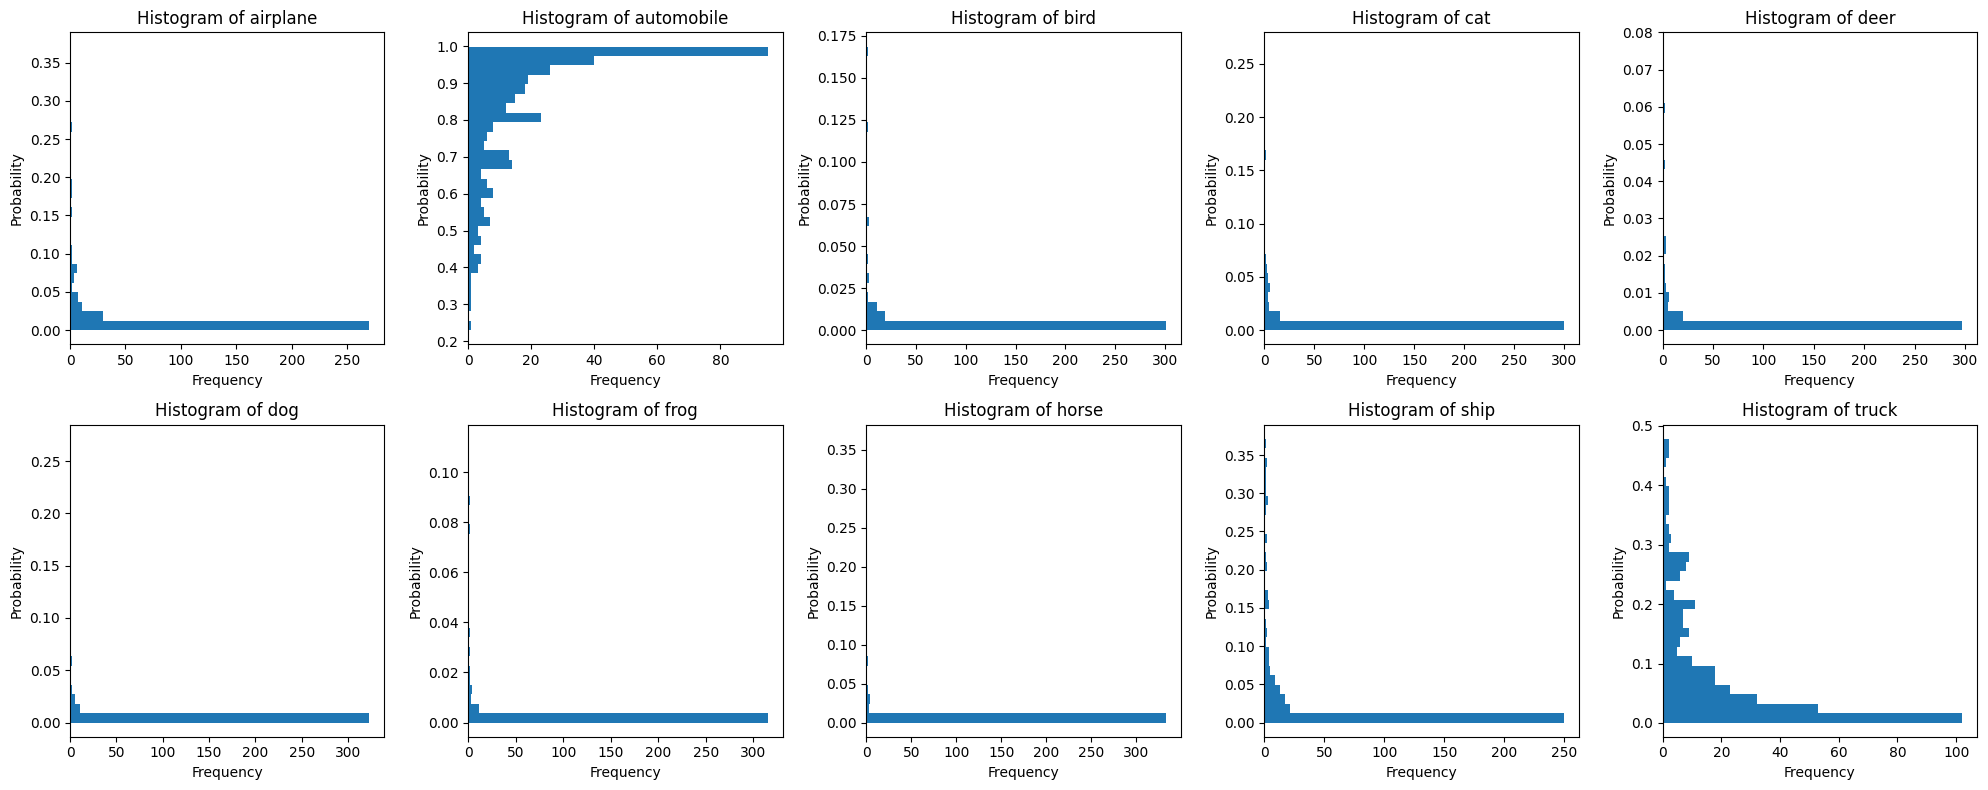

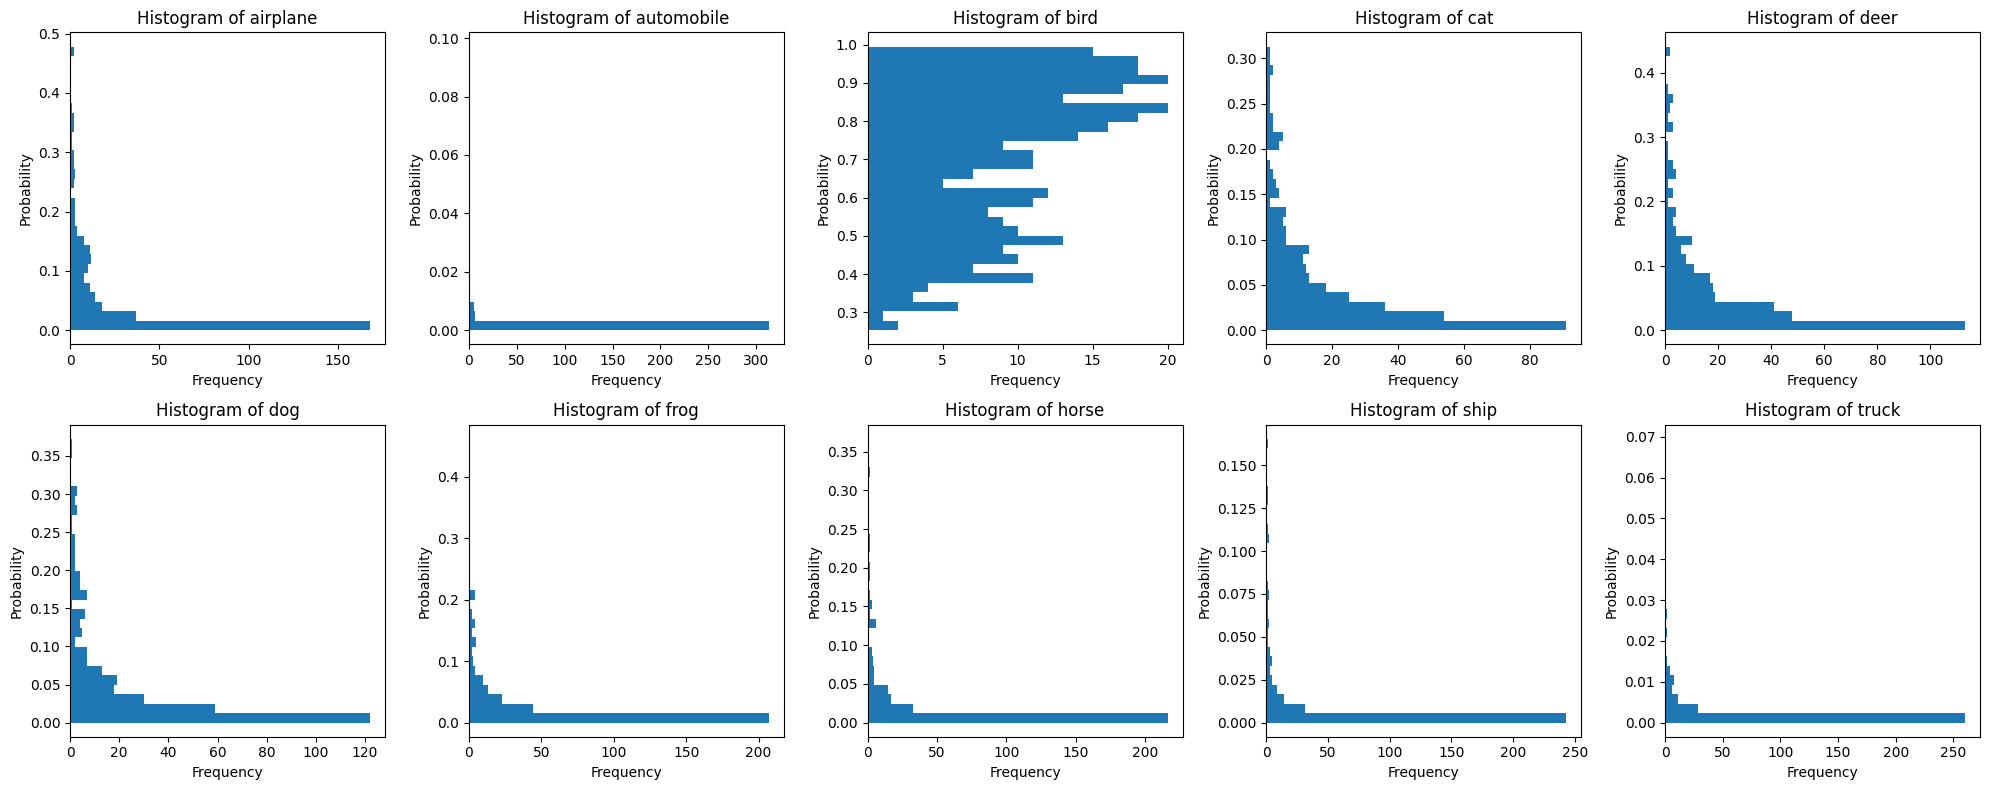

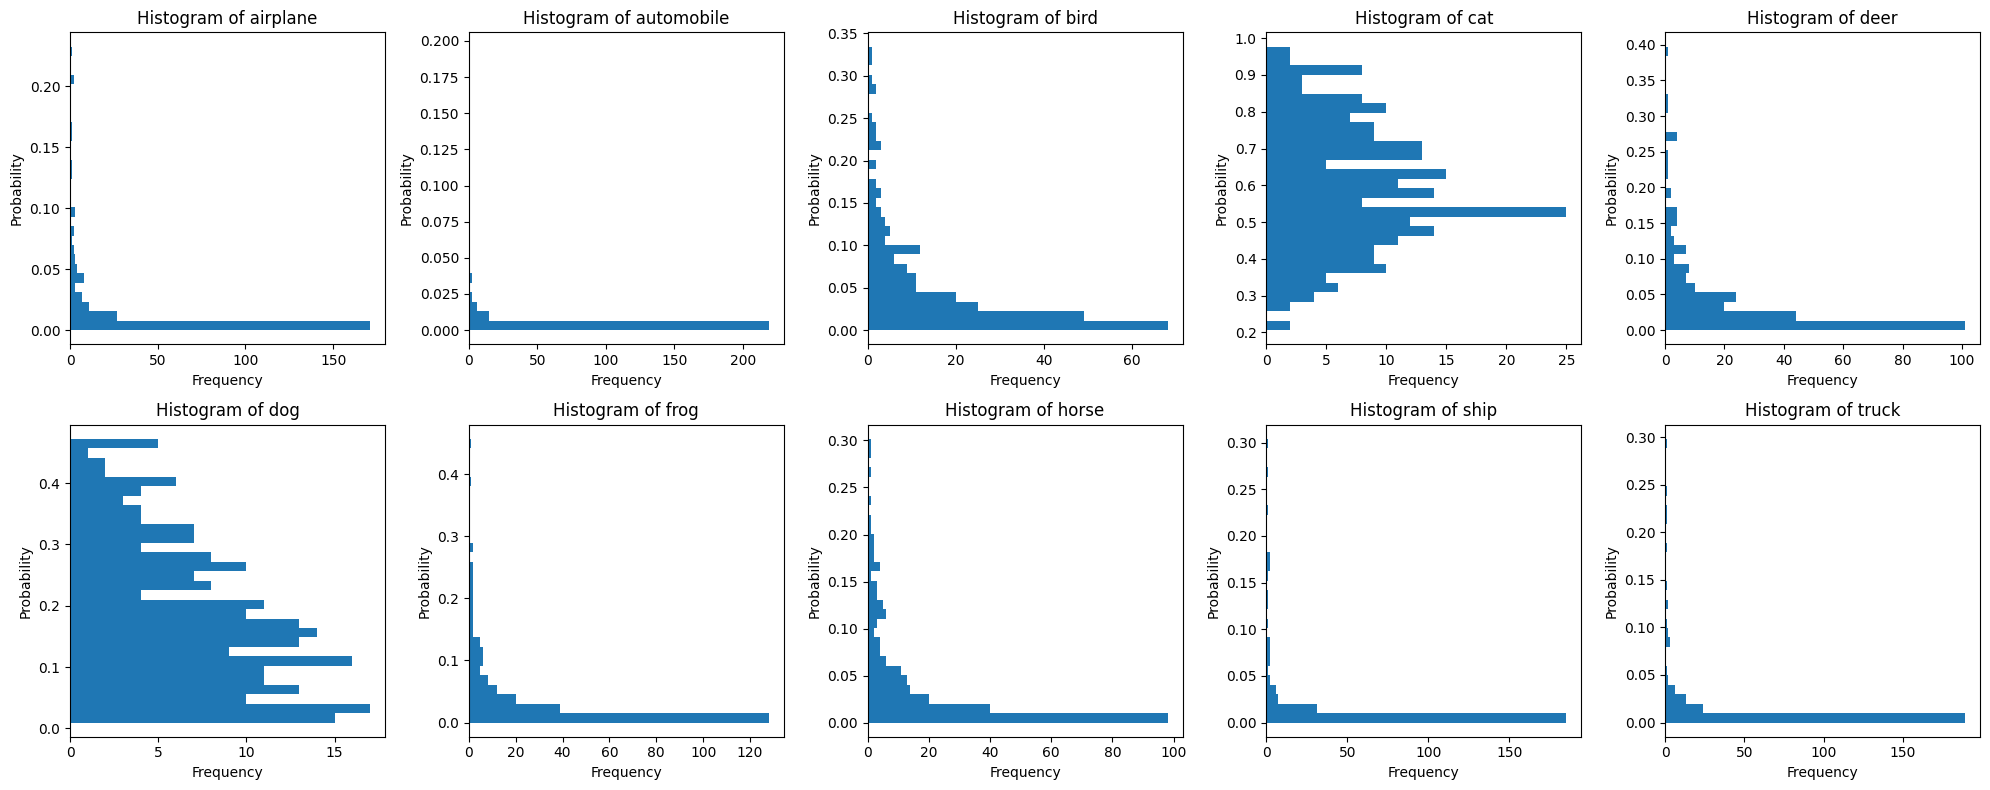

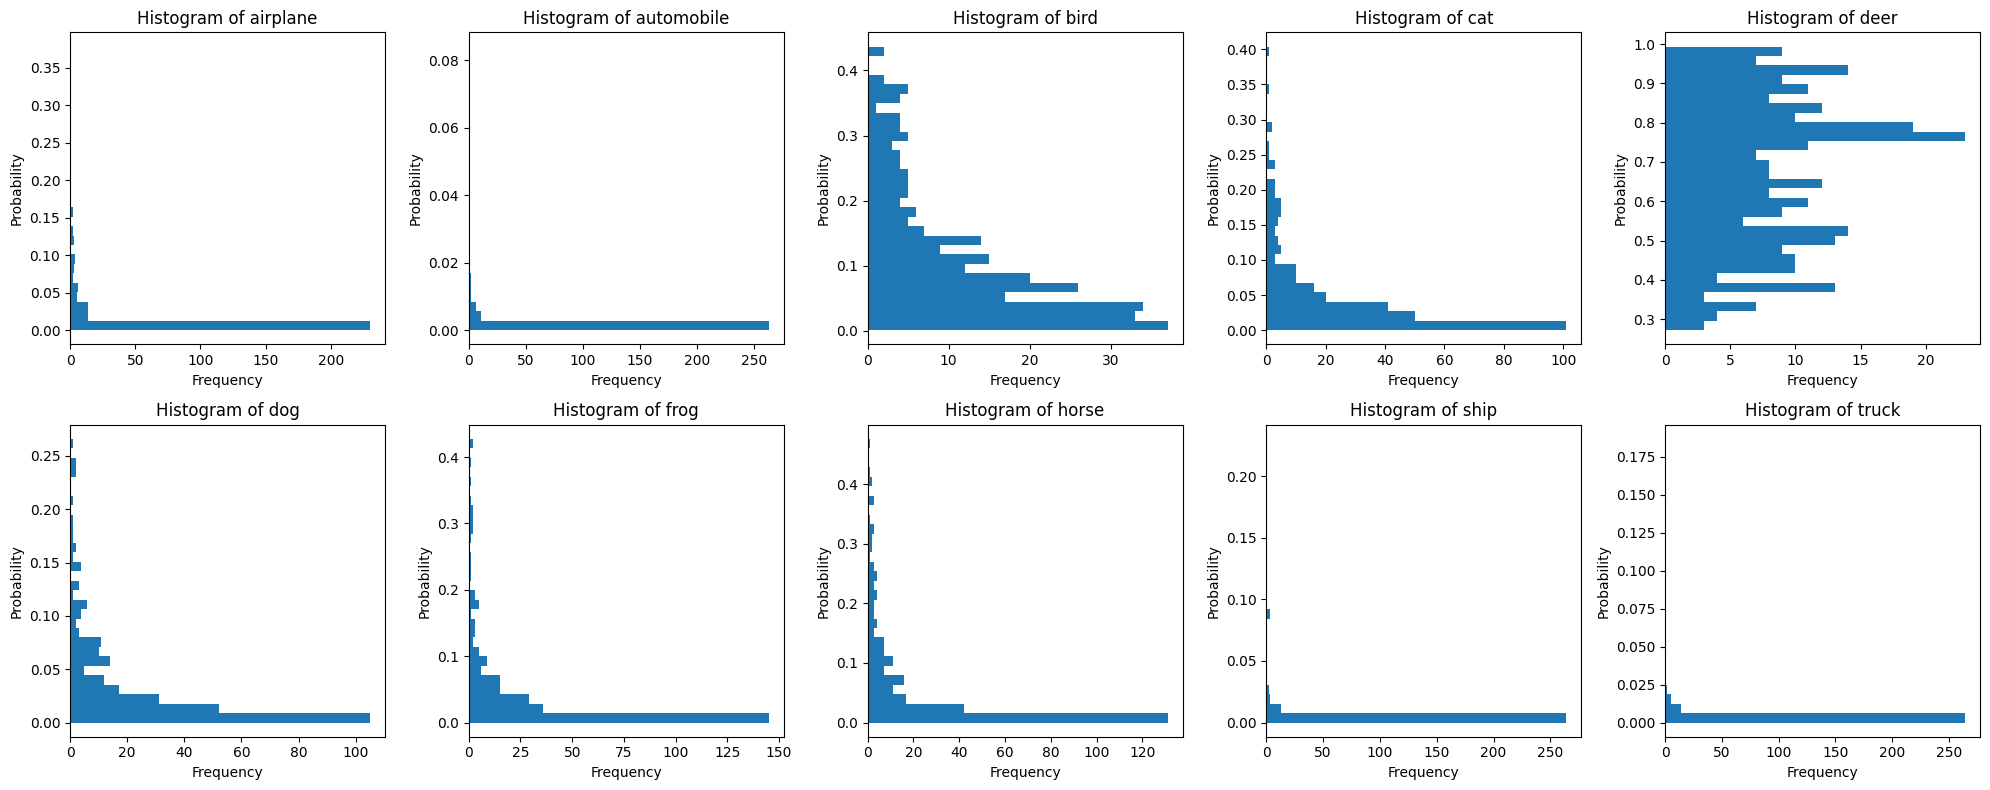

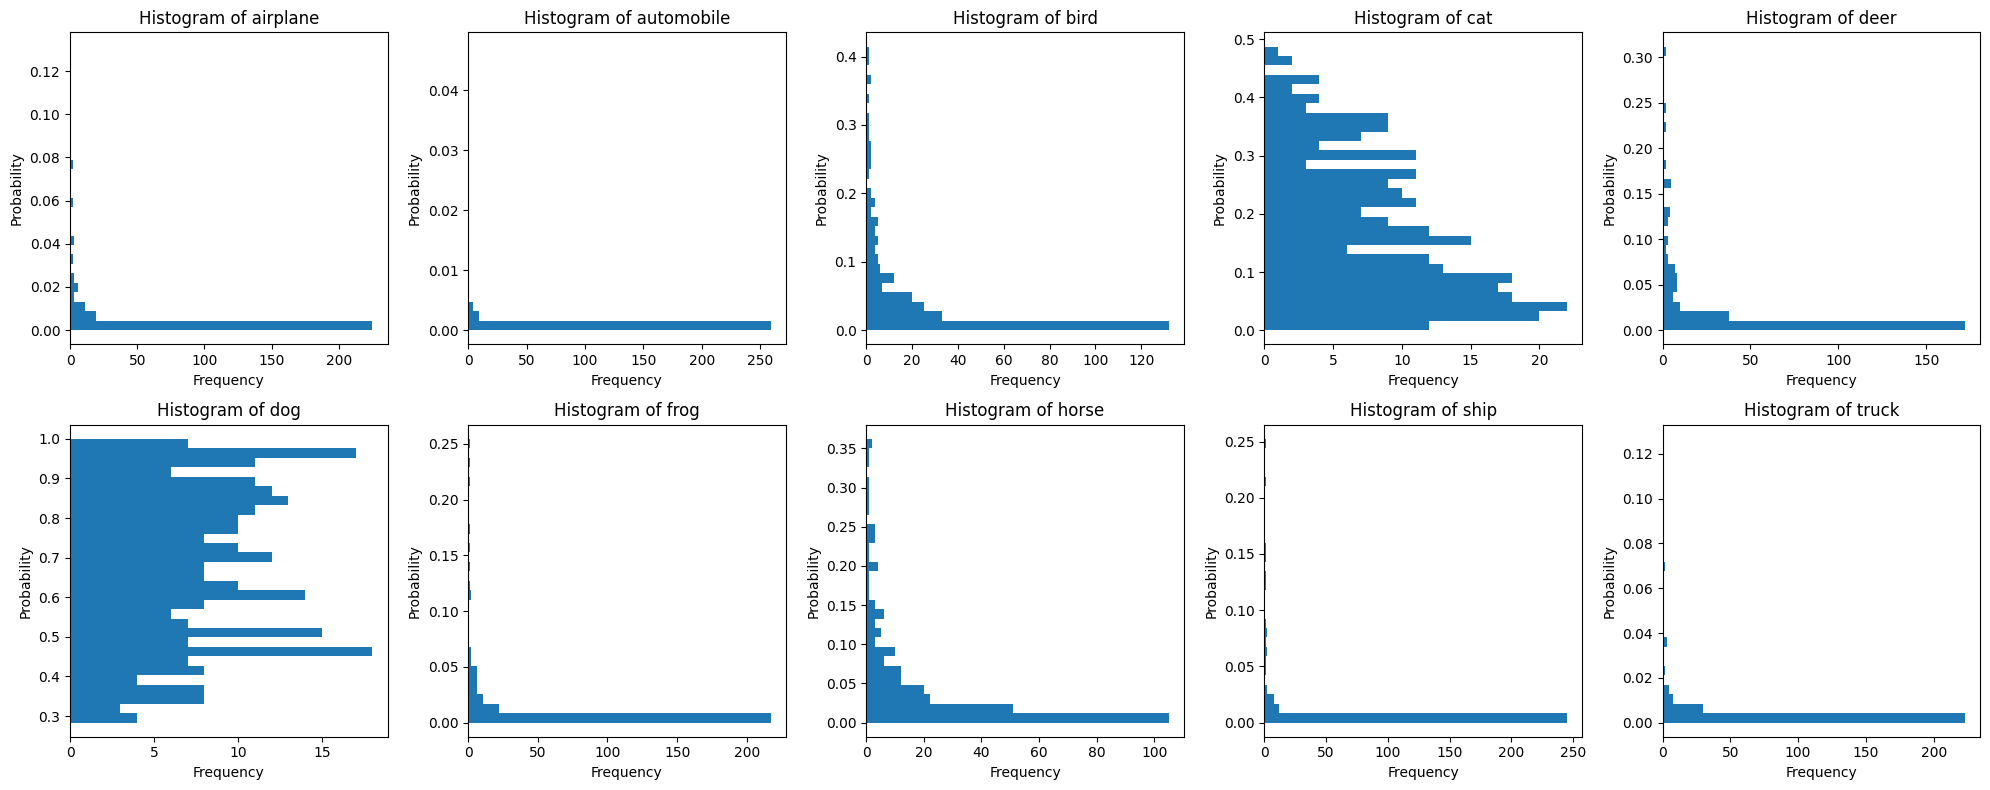

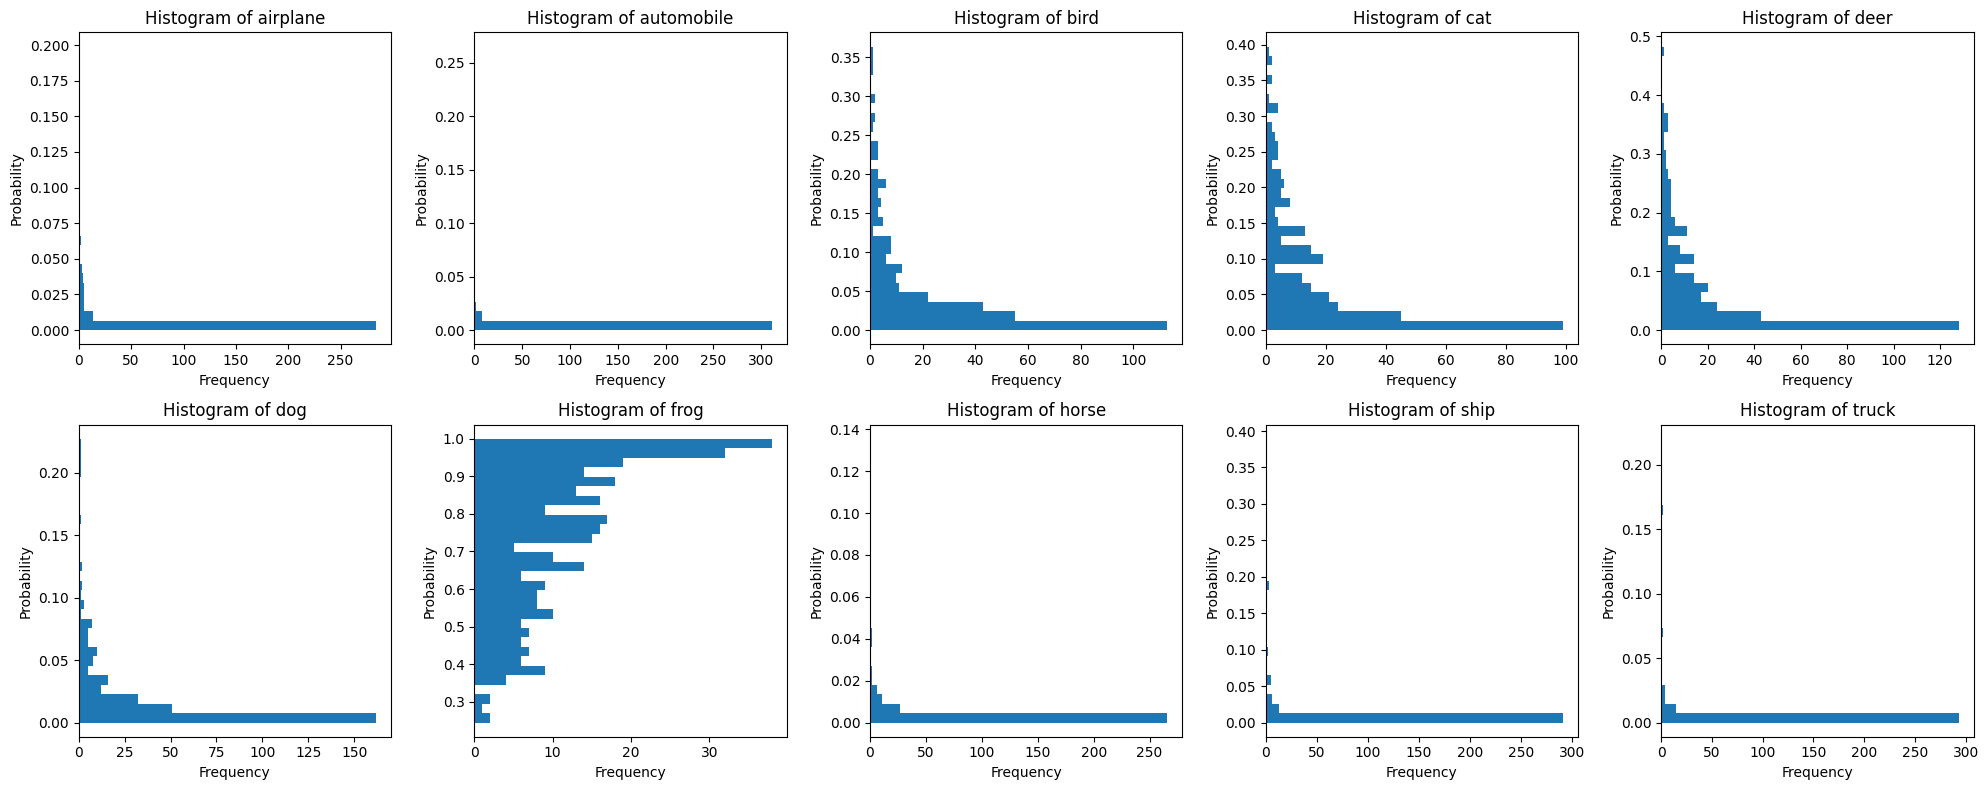

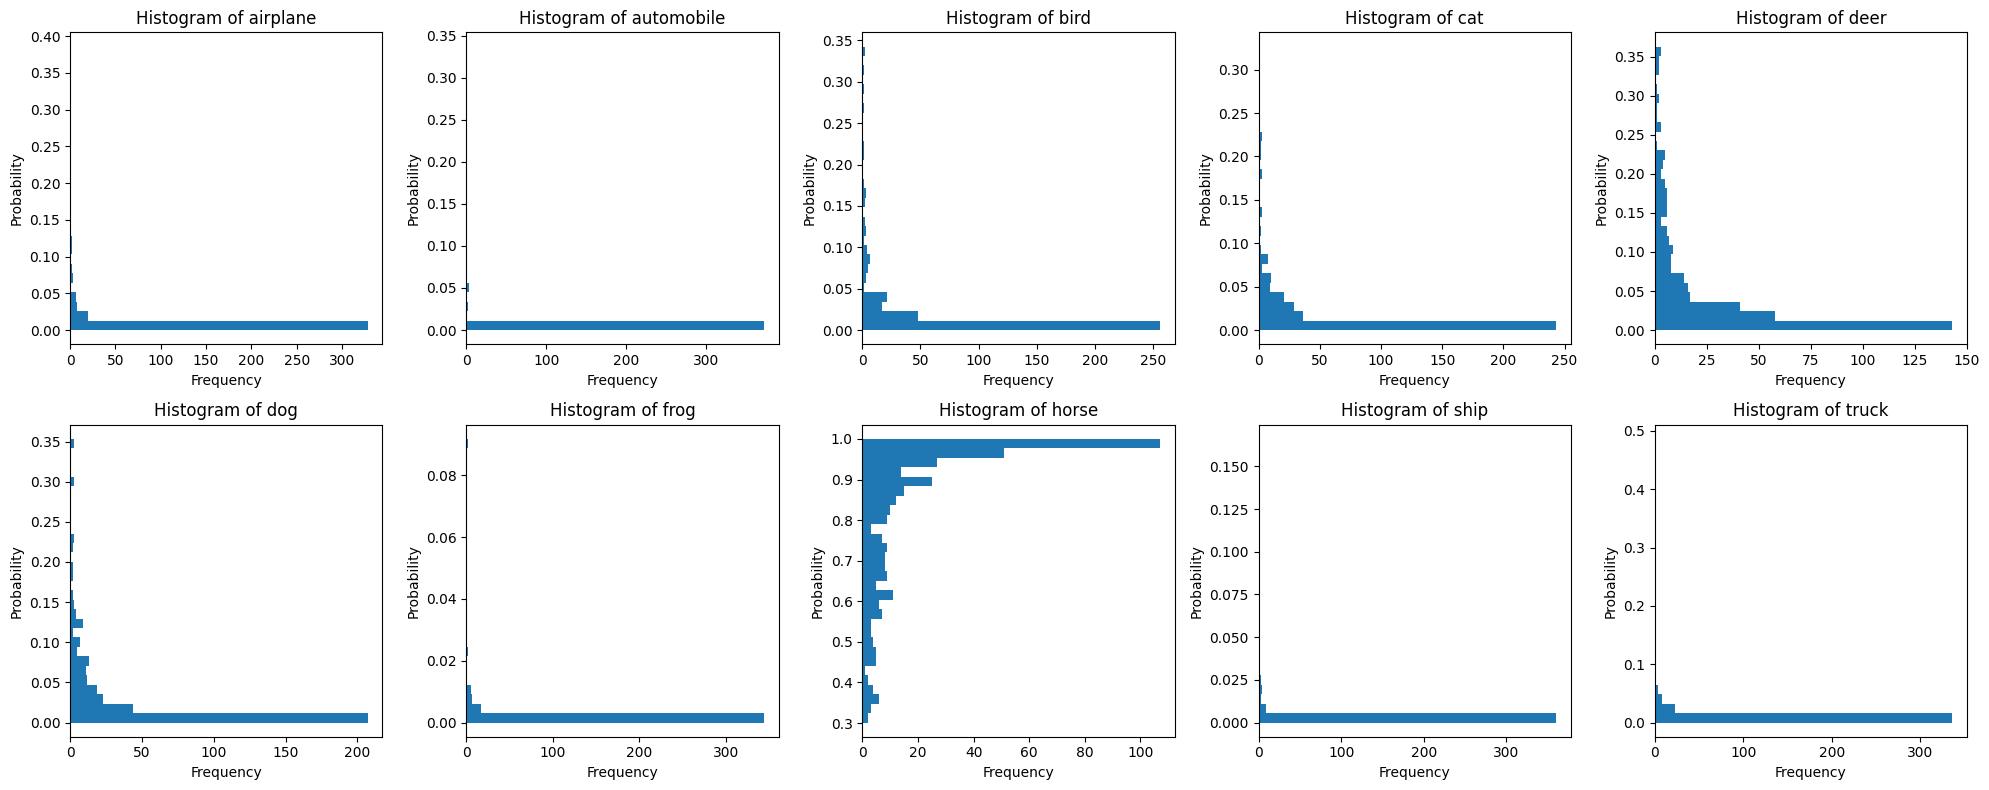

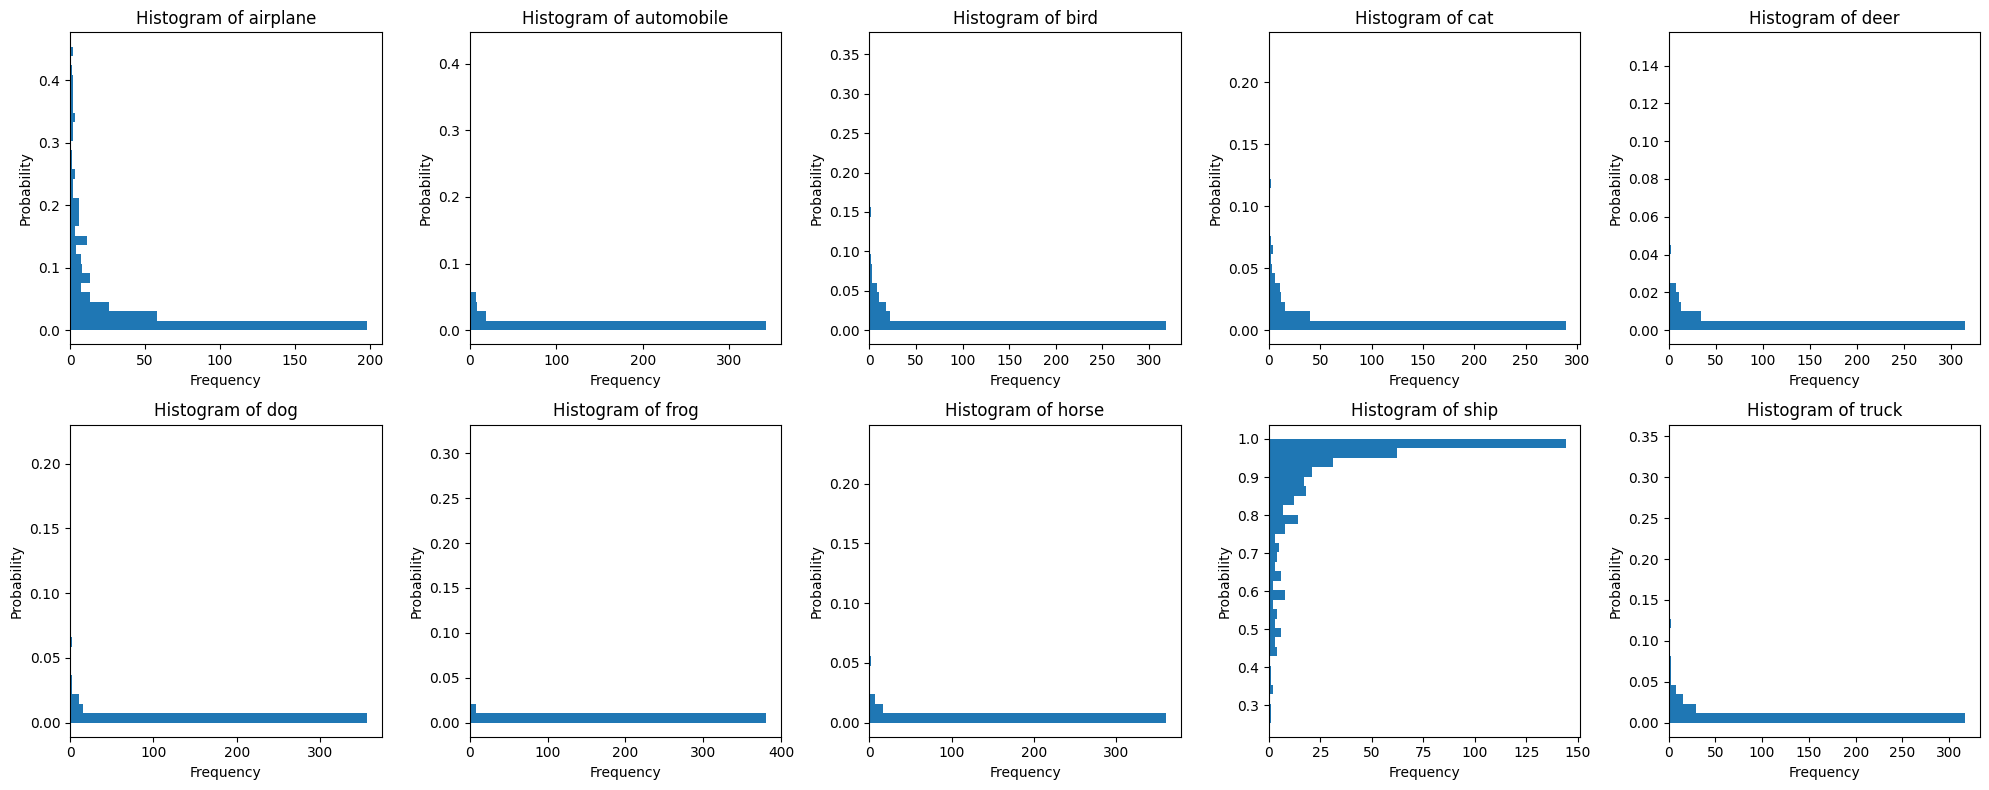

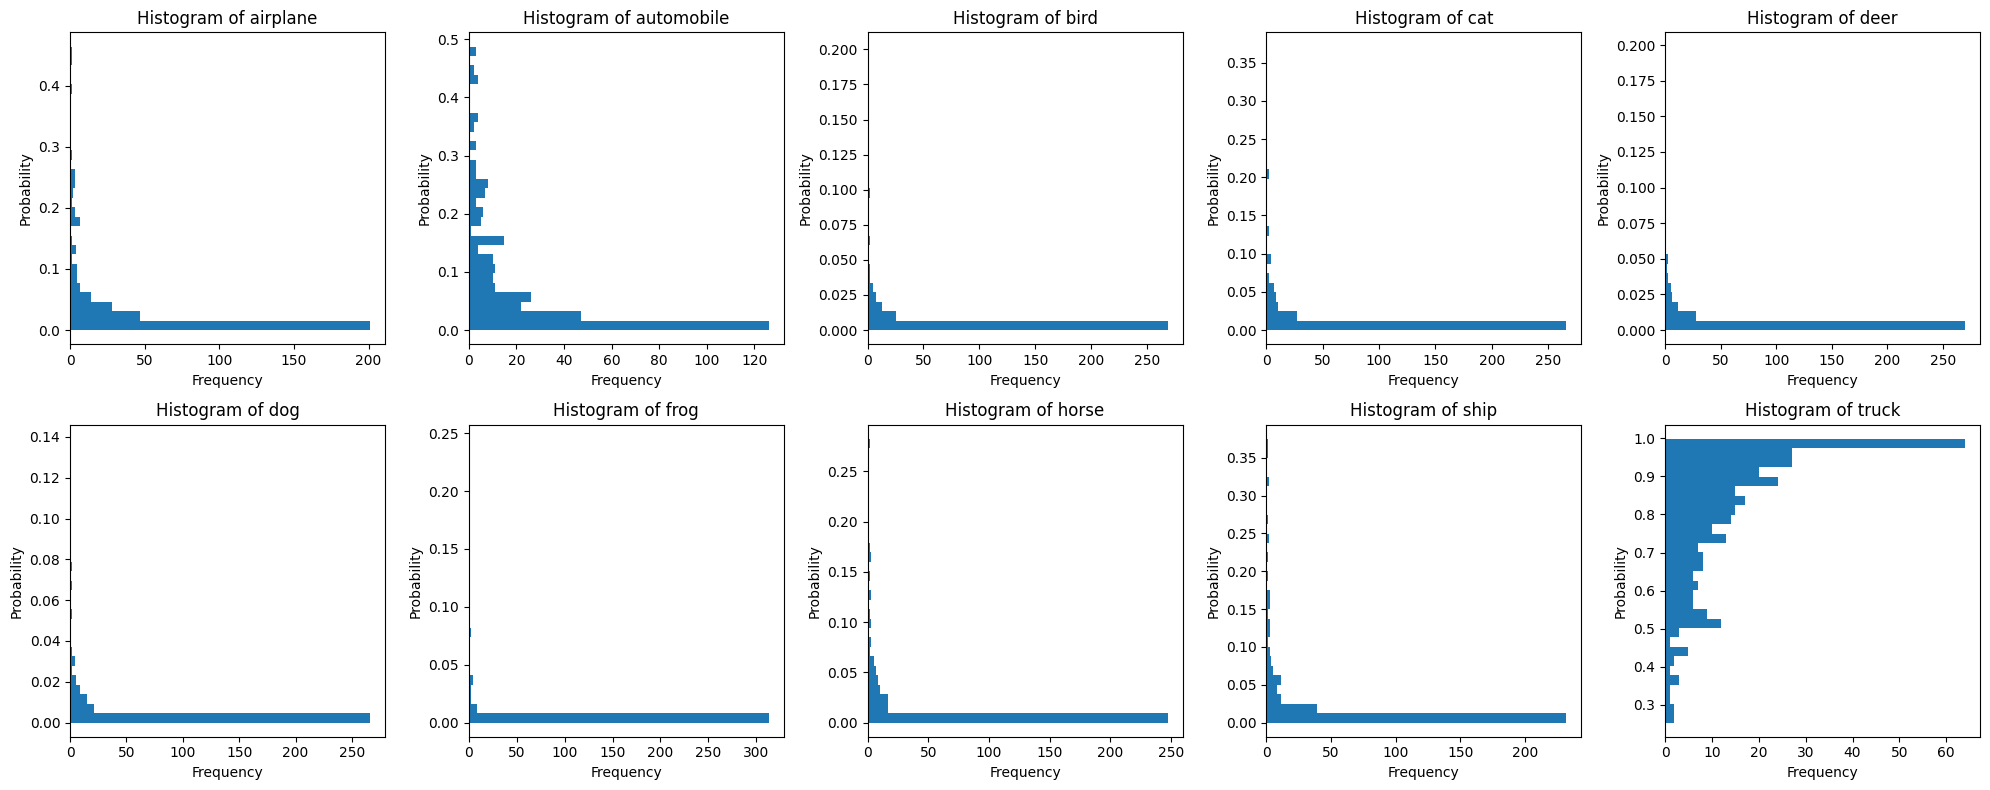

In [5]:
import matplotlib.pyplot as plt

# Select the rows where 'gt_obj_id' is 0
for i in range(10):
    df_zero = df_equal[df_equal.gt_obj_id == i]

    # Create a subplot for each class
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    for i, class_name in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']):
        row = i // 5
        col = i % 5
        axs[row, col].hist(df_zero[class_name], bins=30, orientation='horizontal')
        axs[row, col].set_title('Histogram of ' + class_name)
        axs[row, col].set_xlabel('Frequency')
        axs[row, col].set_ylabel('Probability')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the rows where 'gt_obj_id' is 0
df_zero = df_equal[df_equal.gt_obj_id == 0]

# Create a subplot for each class
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']):
    row = i // 2
    col = i % 2
    axs[row, col].hist(df_zero[class_name], bins=30)
    axs[row, col].set_title('Histogram of ' + class_name)
    axs[row, col].set_xlabel('Probability')
    axs[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
from my_functions import (softmax, 
                          softmax_df, 
                          calculate_logit, 
                          calculate_sigmoid, 
                          calculate_softmax,
                          calculate_hinge_scores,
                          calculate_p_values,
                          calculate_prediction_sets)

## Calibration stage

In [7]:
df_calibration.columns

Index(['gt_obj_id', 'pred_obj_id', 'airplane', 'automobile', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
      dtype='object')

In [8]:
softmax_cols = [
    'airplane', 'automobile', 'bird', 'cat', 
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
alphas_cal = hinge(
    df_calibration[[
    'airplane', 'automobile', 'bird', 'cat', 
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']].values,
    [0,1,2,3,4,5,6,7,8,9],df_calibration[['pred_obj_id']].values
)
cc_std = ConformalClassifier()
cc_std.fit(alphas_cal)
display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

## Testing stage

### Applying the hinge on the testing dataset

In [10]:
hinge_score_cols = [
    'airplane_hinge', 'automobile_hinge', 'bird_hinge', 'cat_hinge', 
    'deer_hinge', 'dog_hinge', 'frog_hinge', 'horse_hinge', 'ship_hinge', 'truck_hinge']
df_testing = calculate_hinge_scores(
    df_testing, 
    softmax_cols, 
    hinge_score_cols)

In [11]:
p_value_cols = [
    'airplane_p_score', 'automobile_p_score', 'bird_p_score', 'cat_p_score', 
    'deer_p_score', 'dog_p_score', 'frog_p_score', 'horse_p_score', 'ship_p_score', 'truck_p_score']
df_testing = calculate_p_values(
    df_testing, 
    hinge_score_cols, 
    p_value_cols, 
    cc_std)

In [12]:
p_set_cols = [
    'airplane_p_set', 'automobile_p_set', 'bird_p_set', 'cat_p_set', 
    'deer_p_set', 'dog_p_set', 'frog_p_set', 'horse_p_set', 'ship_p_set', 'truck_p_set']
df_testing = calculate_prediction_sets(
    df_testing, 
    hinge_score_cols, 
    p_set_cols, cc_std)

In [14]:
df_testing.to_csv('hinge_cifar10.csv',index=False)

In [15]:
df_testing

,gt_obj_id,pred_obj_id,airplane,automobile,bird,cat,deer,dog,frog,horse,...,airplane_p_set,automobile_p_set,bird_p_set,cat_p_set,deer_p_set,dog_p_set,frog_p_set,horse_p_set,ship_p_set,truck_p_set
0,7,7,0.003900,0.000043,0.066297,0.149479,0.146287,0.313681,0.000979,0.319144,...,0,0,0,0,0,1,0,1,0,0
1,0,1,0.061613,0.850465,0.000564,0.000973,0.001339,0.000415,0.000008,0.002297,...,0,1,0,0,0,0,0,0,0,0
2,6,6,0.000062,0.000159,0.204403,0.012123,0.090612,0.005458,0.682553,0.004372,...,0,0,0,0,0,0,1,0,0,0
3,9,9,0.015642,0.052869,0.000833,0.038640,0.000319,0.000923,0.002262,0.000449,...,0,0,0,0,0,0,0,0,1,1
4,5,7,0.000018,0.000006,0.050540,0.121530,0.002190,0.046456,0.006717,0.772385,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,5,0.001855,0.000025,0.031151,0.213213,0.207744,0.397381,0.001080,0.147226,...,0,0,0,0,0,1,0,0,0,0
9996,6,6,0.006566,0.039763,0.004968,0.105709,0.099744,0.023563,0.687131,0.000730,...,0,0,0,0,0,0,1,0,0,0
9997,8,8,0.186546,0.000764,0.066941,0.017658,0.017460,0.005337,0.006174,0.003935,...,0,0,0,0,0,0,0,0,1,0
9998,6,6,0.005546,0.001339,0.213156,0.053063,0.250957,0.008504,0.388231,0.078136,...,0,0,0,0,0,0,1,0,0,0
